In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/intel-image-classification.zip')
zip_ref.extractall()
zip_ref.close()

In [4]:
train_dir="/content/seg_train/seg_train"
test_dir="/content/seg_test/seg_test"

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
train_data=keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            label_mode='categorical',
                                                            batch_size=32,
                                                            image_size=(224,224))
test_data=keras.preprocessing.image_dataset_from_directory(test_dir,
                                                            label_mode='categorical',
                                                            batch_size=32,
                                                            image_size=(224,224))

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [7]:
for image,label in train_data.take(1):
  img=image[0]
  lab=label[0]
  print(img.shape,lab)
  print(img)

(224, 224, 3) tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
tf.Tensor(
[[[232.      237.      240.     ]
  [231.49553 236.49553 239.49553]
  [230.8259  235.65178 238.65178]
  ...
  [211.      221.      230.     ]
  [210.50446 220.50446 229.50446]
  [210.      220.      229.     ]]

 [[232.50447 237.50447 240.50447]
  [232.      237.      240.     ]
  [231.4182  236.24408 239.24408]
  ...
  [211.      221.      230.     ]
  [210.50446 220.50446 229.50446]
  [210.      220.      229.     ]]

 [[232.47768 237.47768 240.47768]
  [232.06104 237.06104 240.06104]
  [231.6821  236.508   239.508  ]
  ...
  [211.1741  221.      230.     ]
  [210.76485 220.59073 229.59073]
  [210.34822 220.1741  229.1741 ]]

 ...

 [[136.47333 151.47333 154.82153]
  [146.10097 161.10097 165.28244]
  [155.11128 170.45949 175.80771]
  ...
  [155.74026 168.74026 176.39206]
  [145.86133 158.86133 166.94762]
  [137.04462 150.04462 158.21872]]

 [[148.92871 163.92871 166.92871]
  [159.52246 174.52246 178.03

In [8]:
img=img/255

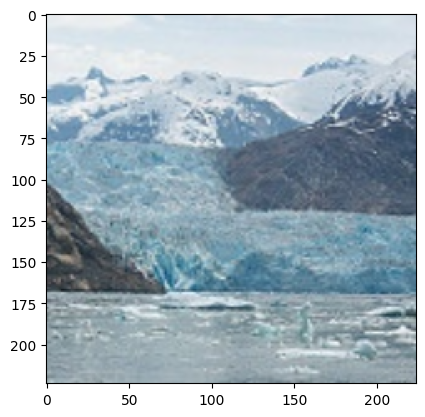

In [9]:
plt.imshow(img)

In [10]:
train_data=train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [12]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
],name='data_augmentation')

In [13]:
keras.mixed_precision.set_global_policy(policy="mixed_float16")

base_model=keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(224,224,3),name='input_layer')
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name='pooling')(x)
x=layers.Dense(6)(x)
outputs=layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

model_0=keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

efficient_history=model_0.fit(train_data,epochs=5,validation_data=test_data)

Epoch 1/5
439/439 [==============================] - 170s 362ms/step - loss: 0.4851 - accuracy: 0.8312 - val_loss: 0.2837 - val_accuracy: 0.8940
Epoch 2/5
439/439 [==============================] - 113s 256ms/step - loss: 0.3231 - accuracy: 0.8796 - val_loss: 0.2499 - val_accuracy: 0.9080
Epoch 3/5
439/439 [==============================] - 94s 214ms/step - loss: 0.2923 - accuracy: 0.8928 - val_loss: 0.2409 - val_accuracy: 0.9093
Epoch 4/5
439/439 [==============================] - 79s 178ms/step - loss: 0.2797 - accuracy: 0.8980 - val_loss: 0.2312 - val_accuracy: 0.9153
Epoch 5/5
439/439 [==============================] - 72s 163ms/step - loss: 0.2677 - accuracy: 0.9007 - val_loss: 0.2238 - val_accuracy: 0.9133


In [31]:
def plot_losses_accuracy(history):
  epochs=range(len(history.history['accuracy']))

  plt.subplot(2,1,1)
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  plt.plot(epochs,acc,label='acc')
  plt.plot(epochs,val_acc,label='val_acc')
  plt.xlabel('ACCURACY')
  plt.legend()
  plt.show()

  plt.subplot(2,1,2)
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  plt.plot(epochs,loss,label='loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.xlabel('LOSS')
  plt.legend()
  plt.show()

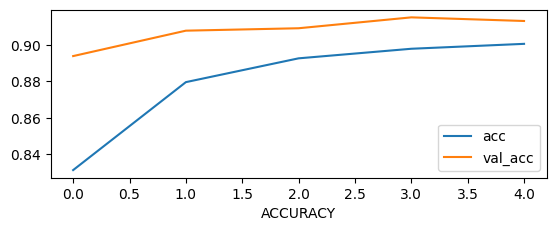

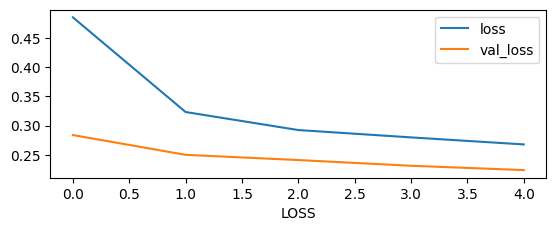

In [24]:
plot_losses_accuracy(efficient_history)

In [26]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_0.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
model_0.fit(train_data,epochs=10,initial_epoch=efficient_history.epoch[-1],validation_data=test_data)

Epoch 5/10
439/439 [==============================] - 79s 155ms/step - loss: 0.2899 - accuracy: 0.8943 - val_loss: 0.2992 - val_accuracy: 0.9003
Epoch 6/10
439/439 [==============================] - 62s 140ms/step - loss: 0.2285 - accuracy: 0.9168 - val_loss: 0.2228 - val_accuracy: 0.9153
Epoch 7/10
439/439 [==============================] - 59s 133ms/step - loss: 0.2040 - accuracy: 0.9253 - val_loss: 0.1933 - val_accuracy: 0.9293
Epoch 8/10
439/439 [==============================] - 55s 125ms/step - loss: 0.1848 - accuracy: 0.9325 - val_loss: 0.2140 - val_accuracy: 0.9270
Epoch 9/10
439/439 [==============================] - 52s 118ms/step - loss: 0.1700 - accuracy: 0.9379 - val_loss: 0.2025 - val_accuracy: 0.9273
Epoch 10/10
439/439 [==============================] - 49s 111ms/step - loss: 0.1568 - accuracy: 0.9419 - val_loss: 0.1909 - val_accuracy: 0.9280


In [29]:
base_model=keras.applications.resnet_v2.ResNet101V2(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(224,224,3),name='input_layer')
x=layers.Rescaling(1./255)(inputs)
# x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name='pooling')(x)
x=layers.Dense(6)(x)
outputs=layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

model_1=keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

resnet_history=model_1.fit(train_data,epochs=5,validation_data=test_data)

Epoch 1/5
439/439 [==============================] - 49s 92ms/step - loss: 0.3250 - accuracy: 0.8829 - val_loss: 0.2494 - val_accuracy: 0.9023
Epoch 2/5
439/439 [==============================] - 42s 95ms/step - loss: 0.2009 - accuracy: 0.9283 - val_loss: 0.2518 - val_accuracy: 0.9017
Epoch 3/5
439/439 [==============================] - 40s 91ms/step - loss: 0.1734 - accuracy: 0.9382 - val_loss: 0.2509 - val_accuracy: 0.9030
Epoch 4/5
439/439 [==============================] - 39s 87ms/step - loss: 0.1572 - accuracy: 0.9441 - val_loss: 0.2554 - val_accuracy: 0.9033
Epoch 5/5
439/439 [==============================] - 39s 88ms/step - loss: 0.1439 - accuracy: 0.9484 - val_loss: 0.2485 - val_accuracy: 0.9107


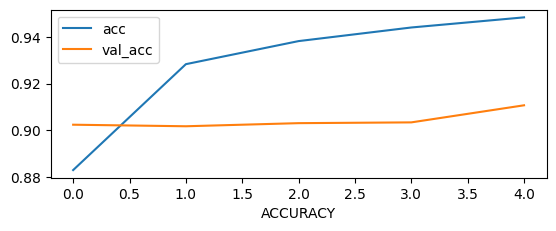

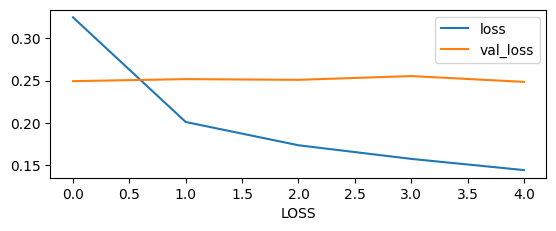

In [32]:
plot_losses_accuracy(resnet_history)

In [33]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_1.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])
model_1.fit(train_data,epochs=10,initial_epoch=efficient_history.epoch[-1],validation_data=test_data)

Epoch 5/10
439/439 [==============================] - 52s 94ms/step - loss: 0.3437 - accuracy: 0.8949 - val_loss: 0.2444 - val_accuracy: 0.9113
Epoch 6/10
439/439 [==============================] - 39s 89ms/step - loss: 0.1905 - accuracy: 0.9348 - val_loss: 0.2777 - val_accuracy: 0.9030
Epoch 7/10
439/439 [==============================] - 40s 90ms/step - loss: 0.1512 - accuracy: 0.9451 - val_loss: 0.2596 - val_accuracy: 0.9087
Epoch 8/10
439/439 [==============================] - 40s 90ms/step - loss: 0.1077 - accuracy: 0.9624 - val_loss: 0.4437 - val_accuracy: 0.8930
Epoch 9/10
439/439 [==============================] - 40s 90ms/step - loss: 0.0829 - accuracy: 0.9702 - val_loss: 0.6520 - val_accuracy: 0.8903
Epoch 10/10
439/439 [==============================] - 40s 91ms/step - loss: 0.0728 - accuracy: 0.9751 - val_loss: 0.3657 - val_accuracy: 0.9083


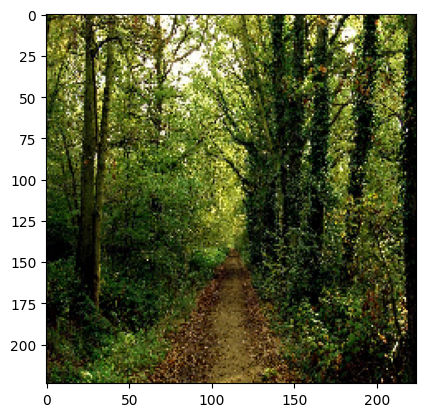

In [183]:
from tensorflow.keras.preprocessing import image

img_path = '/content/forest image.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [184]:
y_pred=np.argmax(model_0.predict(img_array))

1/1 [==============================] - 0s 37ms/step


In [185]:
classname=['Building','Forest','Glacier','Mountain','Sea','Street']

In [186]:
print(classname[y_pred])

Forest
